In [15]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [2]:
import os

import numpy as np
import loader as L


from scipy.interpolate import griddata, interp1d

# from __future__ import print_function # (not needed in python3)

from scipy.ndimage import rotate

from functools import partial
from math import sin, cos, pi

Extracting EDF parameters from /home/ced/Coding/EEGLearn/data_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/home/ced/.local/lib/python3.6/site-packages/mne/io/edf/edf.py:1086: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
/home/ced/.local/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Overlapping events detected. Use find_edf_events for the original events.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')
/home/ced/.local/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')
/home/ced/.local/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')


In [21]:

locs = [[ 35.5,  -0.1 ],    # Fz
        [ 12.2,  56.16],    # FC3
        [  9.9,  27.6 ],    # FC1
        [  9.4,  -0.1 ],    # FCz
        [ 10.5, -28.32],    # FC2
        [ 13  , -57   ],    # FC4
        [-15.1,  87.48],    # C5
        [-16.2,  57.48],    # C3
        [-16.5,  28.44],    # C1
        [-16.8, - 0.1 ],    # Cz
        [-16.3, -29.64],    # C2
        [-15.5, -58.68],    # C4
        [-14.1, -87.6 ],    # C6
        [-40.9,  53.16],    # CP3
        [-39.3,  26.4 ],    # CP1
        [-39.3, - 0.12],    # CPz
        [-38.9, -27.84],    # CP2
        [-40.2, -54.24],    # CP4
        [-65.5,  22.08],    # P1
        [-63.8, - 0.12],    # Pz
        [-65.1, -23.28],    # P2
        [-79.7, - 0.1 ]]    # POz

locs = np.array(locs)

channel_labels = ['Fz'
        , 'FC3'
        , 'FC1'
        , 'FCz'
        , 'FC2'
        , 'FC4'
        , 'C5'
        , 'C3'
        , 'C1'
        , 'Cz'
        , 'C2'
        , 'C4'
        , 'C6'
        , 'CP3'
        , 'CP1'
        , 'CPz'
        , 'CP2'
        , 'CP4'
        , 'P1'
        , 'Pz'
        , 'P2'
        , 'POz'
        ]


gridsize = 32



features = L.train_set.X
labels = L.train_set.y


In [9]:
# channel_labels[0]  # highest
# channel_labels[6]  # leftmost
# channel_labels[12] # rightmost
# channel_labels[21] # lowest

'POz'

In [ ]:
# this now is a function, to find out min/max values of lists.

In [4]:
def minmax(l: list) -> tuple:
    assert len(l) > 0
    minval = l[0]
    maxval = l[0]
    for v in l:
        if v > maxval:
            maxval = v
        if v < minval:
            minval = v
    return (minval, maxval)

In [5]:
def fst(l: list) -> list:
    return list(map(lambda v: v[0], l))

def snd(l: list) -> list:
    return list(map(lambda v: v[1], l))

In [14]:
minmax(fst(locs)), minmax(snd(locs))

((-79.7, 35.5), (-87.6, 87.48))

In [13]:
(87.5 * 2) / (79.7 + 35.5)

1.519097222222222

In [34]:
(-79.7 + 35.5) / 2

-22.1

In [6]:
locsn = list(zip(map(lambda x: (x + 21.1) * 1.519, fst(locs)), snd(locs)))

In [36]:
locsn

[(85.9754, -0.1),
 (50.582699999999996, 56.16),
 (47.089, 27.6),
 (46.329499999999996, -0.1),
 (48.0004, -28.32),
 (51.7979, -57.0),
 (9.114000000000003, 87.48),
 (7.443100000000003, 57.48),
 (6.987400000000002, 28.44),
 (6.531700000000001, -0.1),
 (7.291200000000001, -29.64),
 (8.506400000000001, -58.68),
 (10.633000000000003, -87.6),
 (-30.076199999999993, 53.16),
 (-27.64579999999999, 26.4),
 (-27.64579999999999, -0.12),
 (-27.038199999999993, -27.84),
 (-29.012900000000002, -54.24),
 (-67.44359999999999, 22.08),
 (-64.86129999999999, -0.12),
 (-66.83599999999998, -23.28),
 (-89.01339999999999, -0.1)]

In [ ]:
# testing rotation (and rescaling to square) before actually adding it to the code.

In [7]:
def rotate2D(point: list) -> list:
    degree = (45 * 2 * pi) / 360
    return [point[0] * cos(degree) - point[1] * sin(degree), point[0] * sin(degree) + point[1] * cos(degree)]

In [8]:
locsr = np.array(list(map(rotate2D, locsn)))

In [19]:
locsr

array([[  14.46358637,   14.32216501],
       [ -50.34465932,   29.07757435],
       [ -32.62010861,    6.41218571],
       [ -13.57029837,  -13.71171973],
       [   7.56575972,  -32.48476837],
       [  30.5308202 ,  -50.07935285],
       [-101.81404268,   21.90135976],
       [ -81.78234397,   -0.4933484 ],
       [ -61.5701916 ,  -21.34995789],
       [ -41.71159263,  -41.85301398],
       [ -20.28661071,  -62.2039007 ],
       [   1.10704638,  -81.87900546],
       [  23.06030777, -100.82480029],
       [-105.25779413,  -30.07820115],
       [ -84.61706434,  -47.28182629],
       [ -65.8645925 ,  -66.03429813],
       [ -45.83395445,  -85.20566003],
       [ -28.56265919, -105.26960281],
       [-109.7036573 ,  -78.47782185],
       [ -92.17992492,  -92.34963055],
       [ -77.19965563, -110.12254736],
       [-109.27218075, -109.4136021 ]])

In [69]:
locs

array([[ 35.5 ,  -0.1 ],
       [ 12.2 ,  56.16],
       [  9.9 ,  27.6 ],
       [  9.4 ,  -0.1 ],
       [ 10.5 , -28.32],
       [ 13.  , -57.  ],
       [-15.1 ,  87.48],
       [-16.2 ,  57.48],
       [-16.5 ,  28.44],
       [-16.8 ,  -0.1 ],
       [-16.3 , -29.64],
       [-15.5 , -58.68],
       [-14.1 , -87.6 ],
       [-40.9 ,  53.16],
       [-39.3 ,  26.4 ],
       [-39.3 ,  -0.12],
       [-38.9 , -27.84],
       [-40.2 , -54.24],
       [-65.5 ,  22.08],
       [-63.8 ,  -0.12],
       [-65.1 , -23.28],
       [-79.7 ,  -0.1 ]])

In [9]:
# def gen_images(locs, features, n_gridpoints, normalize=True,
#                augment=False, pca=False, std_mult=0.1, n_components=2, edgeless=False):
# needs defined: locs, features, n_gridpoints

def interpolate(locs, features, n_gridpoints=32, rotate=True, edge_channels=[0, 6, 12, 21]):
    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode

    :param locs: An array with shape [n_electrodes, 2] containing X, Y coordinates for each electrode.
    :param features: Feature matrix as [n_samples, n_features]
                        Features are as columns.
                        Features corresponding to each frequency band are concatenated.
                        (alpha1, alpha2, ..., beta1, beta2,...)
    :param n_gridpoints: Number of pixels in the output images
    :rotate: If the whole image should be rotated by 45 degrees and fit to a square.
    :edge_channels: The indices of the channels with the
                    highest, leftmost, rightmost and lowest coordinates.
                    Only relevant when rotating.
                    (Assuming that Fz is on the x axis to the right.)
    
    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """
    
    if rotate:
        high_x = locs[edge_channels[0]][0]
        high_y = locs[edge_channels[1]][1]
        low_y  = locs[edge_channels[2]][1]
        low_x  = locs[edge_channels[3]][0]
        
        t_x = abs(high_x) + abs(low_x)
        t_y = abs(high_y) + abs(low_y)
        
        factor = t_y / t_x
        
        # centering:
        xdiff = (high_x + low_x) / 2
        ydiff = (high_y + low_y) / 2
        
        locst = zip(map(lambda x: (x - xdiff) * factor, fst(locs)),
                    map(lambda y: (y - ydiff), snd(locs)))
        
        locs = np.array(list(map(rotate2D, locst)))
    
    cut = lambda a: a if len(a.shape) < 3 else a[:, :, 0]
    
    feat_array_temp = []
    nElectrodes = locs.shape[0]     # Number of electrodes
    # Test whether the feature vector length is divisible by number of electrodes
    assert features.shape[1] % nElectrodes == 0
    n_colors = int(features.shape[1] / nElectrodes)
    for c in range(n_colors):
        feat_array_temp.append(cut(features[:, c * nElectrodes : nElectrodes * (c+1)]))
    nSamples = features.shape[0]
    # getting some surrounding values right
    grid_x, grid_y = np.mgrid[
                     min(locs[:, 0]):max(locs[:, 0]):n_gridpoints*1j,
                     min(locs[:, 1]):max(locs[:, 1]):n_gridpoints*1j
                     ]
    temp_interp = []
    for c in range(n_colors):
        temp_interp.append(np.zeros([nSamples, n_gridpoints, n_gridpoints]))
    # Interpolating
    for i in range(nSamples):
        for c in range(n_colors):
            temp_interp[c][i, :, :] = cut(griddata(locs, feat_array_temp[c][i, :], (grid_x, grid_y),
                                    method='cubic', fill_value=np.nan))
    #                                 method='cubic', fill_value=np.nan)# [:, :, 0]
    #                                 method='cubic', fill_value=np.nan)
        print('Interpolating {0}/{1}'.format(i+1, nSamples), end='\r')
    images = np.swapaxes(np.asarray(temp_interp), 0, 1)     # swap axes to have [samples, colors, W, H]
    return images

In [11]:
images = interpolate(locsr, features, gridsize)

In [65]:
a, b = minmax(fst(locs))
a, b

(-79.7, 35.5)

In [66]:
a + b

-44.2

In [67]:
a - (a + b) / 2

-57.6

In [68]:
b - (a + b) / 2

57.6

In [52]:
# mx = interp1d(minmax(fst(locs)), [0, gridsize])
# my = interp1d(minmax(snd(locs)), [0, gridsize])

In [ ]:
mx = interp1d

In [ ]:
images2 = images[:]

In [50]:
for i in range(images.shape[0]):
    print('Saving {0}/{1}'.format(i+1, images.shape[0]), end='\r')
    # for i in range(22):
    #     plt.text(my(locsr[i][1]), mx(locsr[i][0]), channel_labels[i])
    plt.imshow(images[i,0,:,:], cmap='RdYlBu') # , interpolation='bilinear')
    plt.savefig(os.path.join('images3/','%d.png' % i))
    plt.close()

In [14]:
a = np.array([])

In [12]:
images.shape

(288, 1, 32, 32)

In [ ]:
i = 0
plt.imshow(rotate(images[i,0,:,:], 45, cval=np.nan, prefilter=False), cmap='RdYlBu')
plt.savefig(os.path.join('images4/','%d.png' % i))
plt.show()
plt.close()
plt.imshow(images[i,0,:,:], cmap='RdYlBu')
plt.show()
plt.close()
# plt.savefig(os.path.join('images4/','%d.png' % i))
# plt.close()

In [16]:
tight_cap_positions = [
    ['', '', '', '', 'Fp1', 'FPz', 'Fp2', '', '', '', ''],
    ['', '', '', 'AFp3h', '', '', '', 'Afp4h', '', '', ''],
    ['', 'AF7', 'AF5', 'AF3', 'AF1', 'AFz', 'AF2', 'AF4', 'AF6', 'AF8', ''],
    ['', '', 'AFF5h', '', 'AFF1', '', 'AFF2', '', 'AFF6h', '', ''],
    ['', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', ''],
    ['FFT9h', 'FFT7h', 'FFC5h', 'FFC3h', 'FFC1h', '', 'FFC2h', 'FFC4h', 'FFC6h', 'FFT8h', 'FFT10h'],
    ['FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10'],
    ['FTT9h', 'FTT7h', 'FCC5h', 'FCC3h', 'FCC1h', '', 'FCC2h', 'FCC4h', 'FCC6h', 'FTT8h', 'FTT10h'],
    ['M1', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'M2'],
    ['', 'TTP7h', 'CCP5h', 'CCP3h', 'CCP1h', '', 'CCP2h', 'CCP4h', 'CCP6h', 'TTP8h', ''],
    ['TP9', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10'],
    ['TPP9h', 'TPP7h', 'CPP5h', 'CPP3h', 'CPP1h', '', 'CPP2h', 'CPP4h', 'CPP6h', 'TPP8h', 'TPP10h'],
    ['P9', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'P10'],
    ['PPO9h', '', 'PPO5h', '', 'PPO1', '', 'PPO2', '', 'PPO6h', '', 'PPO10h'],
    ['PO9', 'PO7', 'PO5', 'PO3', 'PO1', 'POz', 'PO2', 'PO4', 'PO6', 'PO8', 'PO10'],
    ['POO9h', '', '', 'POO3h', '', '', '', 'POO4h', '', '', 'POO10h'],
    ['', '', '', '', 'O1', 'Oz', 'O2', '', '', '', ''],
    ['', '', '', '', 'OI1h', '', 'OI2h', '', '', '', ''],
    ['', '', '', '', 'I1', 'Iz', 'I2', '', '', '', '']]



In [17]:
def mapper(locs):
    def actual(values):
        nmap = np.empty((19, 11))
        for i, row in enumerate(tight_cap_positions):
            for j, col in enumerate(row):
                if col in locs:
                    ind = locs.index(col)
                    nmap[i, j] = values[ind]
                else:
                    nmap[i, j] = np.nan
        return nmap
    return actual

In [22]:
a = mapper(channel_labels)

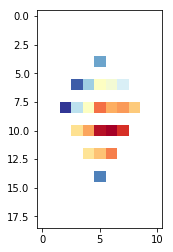

In [24]:
plt.imshow(a(features[0, :, 0]), cmap='RdYlBu')

In [19]:
# L.train_set.X.shape

(288, 22, 1125)